<a href="https://colab.research.google.com/github/Aomaphisara/bsc_dpdm22/blob/main/Association_rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data



In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import json
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

In [2]:
#เชื่อม google drive 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_train = pd.read_csv('/content/drive/MyDrive/bsc_DPDM_data/Train.csv', sep=',')
data_test = pd.read_csv('/content/drive/MyDrive/bsc_DPDM_data/Test.csv', sep=',')
existing  = data_train.drop('Var_1', axis=1)
new  = data_test.drop('Var_1', axis=1)
existing.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,A


## existing_customers

In [4]:
# 1. Remove duplicated rows (38 in total)
existing.drop_duplicates(inplace=True)

# 2. Create a calculated column (Work_Experience_to_Age_Ratio) that could potentialy be a relevant feature to the model (to be tested later)
existing["Work_Experience_to_Age_Ratio"] = existing["Work_Experience"] / existing["Age"]

# 3. Treat missing values:
#    *   3.1 Ever_Married: consider missing values as No
#    *   3.2 Graduated: consider missing values as No
#    *   3.3 Profession: delete (it´s not representative the amount of blanks)
#    *   3.4 Family_Size: mean
#    *   3.5 Var_1: delete (it´s not representative the amount of blanks)
#    *   3.6 Work_Experience: estimate based on Age
existing["Ever_Married"].fillna("No", inplace=True)
existing["Graduated"].fillna("No", inplace=True)
existing.dropna(subset=["Profession"], inplace=True)
existing["Family_Size"].fillna(existing["Family_Size"].mean(), inplace=True)
existing["Work_Experience"].replace(0, np.nan, inplace=True)
existing["Work_Experience"].fillna(existing["Work_Experience"].sum() / existing["Age"].sum() * existing["Age"], inplace=True)
existing["Work_Experience_to_Age_Ratio"].replace(0, np.nan, inplace=True)
existing["Work_Experience_to_Age_Ratio"].fillna(existing["Work_Experience"] / existing["Age"], inplace=True)

# 4. Remove column ID as it´s not important to the model
existing.drop(["ID"], axis=1, inplace=True)

# 5. Convert categorical variables (Gender, Ever_Married, Graduated, Profession, Spending_Score, Var_1, Segmentation) to dummies
existing = pd.concat([existing, pd.get_dummies(existing["Gender"], prefix="Gender")], axis=1)
existing = pd.concat([existing, pd.get_dummies(existing["Ever_Married"], prefix="Ever_Married")], axis=1)
existing= pd.concat([existing, pd.get_dummies(existing["Graduated"], prefix="Graduated")], axis=1)
existing = pd.concat([existing, pd.get_dummies(existing["Profession"], prefix="Profession")], axis=1)
existing["Spending_Score_Level"] = existing["Spending_Score"].apply(lambda x: ["Low", "Average", "High"].index(x))+1 #Label encoding
#target variable for the ML model (label encoding)
existing["Segmentation_Level"] = existing["Segmentation"].apply(lambda x: ["A", "B", "C", "D"].index(x))+1 #Label encoding
#target variable for the DL model (one-hot encoding)
existing = pd.concat([existing, pd.get_dummies(existing["Segmentation"], prefix="Segmentation")], axis=1)
Segmentation_encoding_dl = np.asarray(existing[["Segmentation_A", "Segmentation_B", "Segmentation_C", "Segmentation_D"]])
#creating for the DL model the response variable through the concatenation of the created dummy columns, forming an array

# 6. Convert all numerical variables (Age, Work_Experience, Family_Size, Work_Experience_to_Age_Ratio) to categorical ranges (to be used in next step when analyzing correlations)
existing["Age_Range"] = np.where(existing.Age>=60, "60+", np.where(existing.Age>=50, "50-60", np.where(existing.Age>=40, "40-50", np.where(existing.Age>=30, "30-40", np.where(existing.Age>=18, "18-30", "18-")))))
existing["Work_Experience_Range"] = np.where(existing.Work_Experience>=10, "10+", np.where(existing.Work_Experience>=5, "5-10", "0-5"))
existing["Family_Size_Range"] = np.where(existing.Family_Size>=6, "6+", np.where(existing.Family_Size>=3, "3-6", "0-3"))
existing["Work_Experience_to_Age_Ratio_Range"] = np.where(existing.Work_Experience_to_Age_Ratio>=0.5, "0.5+", np.where(existing.Work_Experience_to_Age_Ratio>=0.4,
                                                                                                                   "0.4-0.5", np.where(existing.Work_Experience_to_Age_Ratio>=0.3,
                                                                                                                    "0.3-0.4", np.where(existing.Work_Experience_to_Age_Ratio>=0.2,
                                                                                                                    "0.2-0.3", np.where(existing.Work_Experience_to_Age_Ratio>=0.1,
                                                                                                                    "0.1-0.2", "0+")))))


In [5]:
existing.head(3)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation,Work_Experience_to_Age_Ratio,...,Spending_Score_Level,Segmentation_Level,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Age_Range,Work_Experience_Range,Family_Size_Range,Work_Experience_to_Age_Ratio_Range
0,Male,No,22,No,Healthcare,1.000000,Low,4.0,D,0.045455,...,1,4,0,0,0,1,18-30,0-5,3-6,0+
1,Female,Yes,38,Yes,Engineer,2.077749,Average,3.0,A,0.054678,...,2,1,1,0,0,0,30-40,0-5,3-6,0+
2,Female,Yes,67,Yes,Engineer,1.000000,Low,1.0,B,0.014925,...,1,2,0,1,0,0,60+,0-5,0-3,0+


In [6]:
existing.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Segmentation',
       'Work_Experience_to_Age_Ratio', 'Gender_Female', 'Gender_Male',
       'Ever_Married_No', 'Ever_Married_Yes', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Level', 'Segmentation_Level',
       'Segmentation_A', 'Segmentation_B', 'Segmentation_C', 'Segmentation_D',
       'Age_Range', 'Work_Experience_Range', 'Family_Size_Range',
       'Work_Experience_to_Age_Ratio_Range'],
      dtype='object')

In [7]:
existing1 = existing[['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession','Spending_Score_Level','Segmentation'
       ,'Work_Experience_Range','Family_Size_Range']]
existing1

,Gender,Ever_Married,Age_Range,Graduated,Profession,Spending_Score_Level,Segmentation,Work_Experience_Range,Family_Size_Range
0,Male,No,18-30,No,Healthcare,1,D,0-5,3-6
1,Female,Yes,30-40,Yes,Engineer,2,A,0-5,3-6
2,Female,Yes,60+,Yes,Engineer,1,B,0-5,0-3
3,Male,Yes,60+,Yes,Lawyer,3,B,0-5,0-3
4,Female,Yes,40-50,Yes,Entertainment,3,A,0-5,6+
...,...,...,...,...,...,...,...,...,...
8062,Male,Yes,40-50,Yes,Artist,3,B,0-5,3-6
8064,Male,No,30-40,No,Executive,1,D,0-5,3-6
8065,Female,No,30-40,Yes,Healthcare,1,D,0-5,0-3
8066,Female,No,18-30,Yes,Healthcare,1,B,0-5,3-6


In [8]:
existing1.columns

Index(['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession',
       'Spending_Score_Level', 'Segmentation', 'Work_Experience_Range',
       'Family_Size_Range'],
      dtype='object')

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [12]:
# Performing one-hot encoding
existing1_encode = pd.get_dummies(existing1, columns=['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession',
       'Spending_Score_Level', 'Segmentation', 'Work_Experience_Range',
       'Family_Size_Range'])
# Printing the encoded data
print(existing1_encode.head())

   Gender_Female  Gender_Male  Ever_Married_No  Ever_Married_Yes  \
0              0            1                1                 0   
1              1            0                0                 1   
2              1            0                0                 1   
3              0            1                0                 1   
4              1            0                0                 1   

   Age_Range_18-30  Age_Range_30-40  Age_Range_40-50  Age_Range_50-60  \
0                1                0                0                0   
1                0                1                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                1                0   

   Age_Range_60+  Graduated_No  ...  Segmentation_A  Segmentation_B  \
0              0             1  ...               0               0   
1         

In [13]:
existing1_encode.head(3)

,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+
0,0,1,1,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,1,0
1,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [14]:
existing1_encode.columns

Index(['Gender_Female', 'Gender_Male', 'Ever_Married_No', 'Ever_Married_Yes',
       'Age_Range_18-30', 'Age_Range_30-40', 'Age_Range_40-50',
       'Age_Range_50-60', 'Age_Range_60+', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Level_1',
       'Spending_Score_Level_2', 'Spending_Score_Level_3', 'Segmentation_A',
       'Segmentation_B', 'Segmentation_C', 'Segmentation_D',
       'Work_Experience_Range_0-5', 'Work_Experience_Range_10+',
       'Work_Experience_Range_5-10', 'Family_Size_Range_0-3',
       'Family_Size_Range_3-6', 'Family_Size_Range_6+'],
      dtype='object')

In [15]:
#เปลี่ยนชื่อ columns
existing1_encode.rename(columns={'Gender_Female':'Female', 'Gender_Male':'Male'
,'Ever_Married_No':'Singer', 'Ever_Married_Yes':'Married'
,'Graduation_No':'Studying', 'Graduation_Yes':'Graduated'
,'Profession_Artist':'Artist', 'Profession_Doctor':'Doctor','Profession_Engineer':'Engineer'
,'Profession_Entertainment':'Entertainment','Profession_Executive':'Executive','Profession_Healthcare':'Healthcare'
,'Profession_Homemaker':'Homemaker','Profession_Lawyer':'Lawyer', 'Profession_Marketing':'Marketing'
,'Spending_Score_Level_1':'Spending_Score_Level1', 'Spending_Score_Level_2':'Spending_Score_Level2', 'Spending_Score_Level_3':'Spending_Score_Level3'
,'Segmentation_A':'A', 'Segmentation_B':'B','Segmentation_C':'C','Segmentation_D':'D'}, inplace=True)
existing1_encode.head(3)

,Female,Male,Singer,Married,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,A,B,C,D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+
0,0,1,1,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,1,0
1,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [16]:
pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import mlxtend
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

In [18]:
# Applying Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(existing1_encode, min_support=0.05, use_colnames=True)

# Generating association rules
rules0 = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sorting the rules by lift in descending order
rules0 = rules0.sort_values(['lift'], ascending=False)

# Generating association rules
rules1 = association_rules(frequent_itemsets, metric="support", min_threshold=0.05)
rules1 = rules1.sort_values(['support'], ascending=False)

In [19]:
rules0.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17362,"(Graduated_No, Healthcare, Spending_Score_Level1)","(Age_Range_18-30, Family_Size_Range_3-6, Singe...",0.104230,0.089753,0.061304,0.588164,6.553123,0.051949,2.210218
17359,"(Age_Range_18-30, Family_Size_Range_3-6, Singe...","(Graduated_No, Healthcare, Spending_Score_Level1)",0.089753,0.104230,0.061304,0.683029,6.553123,0.051949,2.826037
17655,"(Graduated_No, Healthcare)","(Age_Range_18-30, Family_Size_Range_3-6, Singe...",0.107754,0.071501,0.050101,0.464953,6.502797,0.042396,1.735362


In [20]:
rules1.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
306,(Work_Experience_Range_0-5),(Graduated_Yes),0.779708,0.618706,0.475453,0.609784,0.985579,-0.006957,0.977135
307,(Graduated_Yes),(Work_Experience_Range_0-5),0.618706,0.779708,0.475453,0.768464,0.985579,-0.006957,0.951437
163,(Married),(Work_Experience_Range_0-5),0.575655,0.779708,0.465760,0.809097,1.037692,0.016918,1.153947


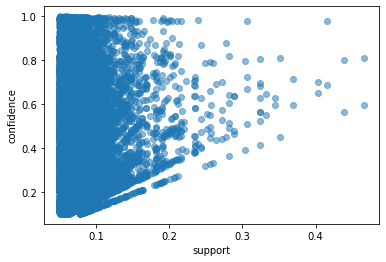

In [21]:
# Filter rules based on support and confidence thresholds
rules0 = rules0[(rules0['support'] >= 0.05) & (rules0['confidence'] >= 0.1)]

# Visualize rules using scatter plots, heat maps, or network diagrams
plt.scatter(rules0['support'], rules0['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

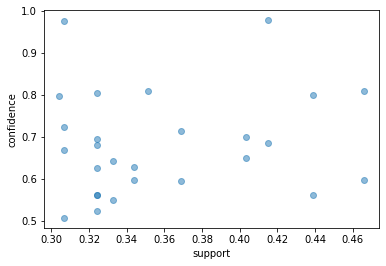

In [22]:
# Filter rules based on support and confidence thresholds
rules2 = rules0[(rules0['support'] >= 0.3) & (rules0['confidence'] >= 0.5)]

# Visualize rules using scatter plots, heat maps, or network diagrams
plt.scatter(rules2['support'], rules2['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

## new_customers

In [23]:
# 1. Remove duplicated rows (38 in total)
new.drop_duplicates(inplace=True)

# 2. Create a calculated column (Work_Experience_to_Age_Ratio) that could potentialy be a relevant feature to the model (to be tested later)
new["Work_Experience_to_Age_Ratio"] = new["Work_Experience"] / new["Age"]

# 3. Treat missing values:
#    *   3.1 Ever_Married: consider missing values as No
#    *   3.2 Graduated: consider missing values as No
#    *   3.3 Profession: delete (it´s not representative the amount of blanks)
#    *   3.4 Family_Size: mean
#    *   3.5 Var_1: delete (it´s not representative the amount of blanks)
#    *   3.6 Work_Experience: estimate based on Age
new["Ever_Married"].fillna("No", inplace=True)
new["Graduated"].fillna("No", inplace=True)
new.dropna(subset=["Profession"], inplace=True)
new["Family_Size"].fillna(new["Family_Size"].mean(), inplace=True)
new["Work_Experience"].replace(0, np.nan, inplace=True)
new["Work_Experience"].fillna(new["Work_Experience"].sum() / new["Age"].sum() * new["Age"], inplace=True)
new["Work_Experience_to_Age_Ratio"].replace(0, np.nan, inplace=True)
new["Work_Experience_to_Age_Ratio"].fillna(new["Work_Experience"] / new["Age"], inplace=True)

# 4. Remove column ID as it´s not important to the model
new.drop(["ID"], axis=1, inplace=True)

# 5. Convert categorical variables (Gender, Ever_Married, Graduated, Profession, Spending_Score, Var_1, Segmentation) to dummies
new = pd.concat([new, pd.get_dummies(new["Gender"], prefix="Gender")], axis=1)
new = pd.concat([new, pd.get_dummies(new["Ever_Married"], prefix="Ever_Married")], axis=1)
new= pd.concat([new, pd.get_dummies(new["Graduated"], prefix="Graduated")], axis=1)
new = pd.concat([new, pd.get_dummies(new["Profession"], prefix="Profession")], axis=1)
new["Spending_Score_Level"] = new["Spending_Score"].apply(lambda x: ["Low", "Average", "High"].index(x))+1 #Label encoding
#target variable for the ML model (label encoding)
new["Segmentation_Level"] = new["Segmentation"].apply(lambda x: ["A", "B", "C", "D"].index(x))+1 #Label encoding
#target variable for the DL model (one-hot encoding)
new = pd.concat([new, pd.get_dummies(new["Segmentation"], prefix="Segmentation")], axis=1)
Segmentation_encoding_dl = np.asarray(new[["Segmentation_A", "Segmentation_B", "Segmentation_C", "Segmentation_D"]])
#creating for the DL model the response variable through the concatenation of the created dummy columns, forming an array

# 6. Convert all numerical variables (Age, Work_Experience, Family_Size, Work_Experience_to_Age_Ratio) to categorical ranges (to be used in next step when analyzing correlations)
new["Age_Range"] = np.where(new.Age>=60, "60+", np.where(new.Age>=50, "50-60", np.where(new.Age>=40, "40-50", np.where(new.Age>=30, "30-40", np.where(new.Age>=18, "18-30", "18-")))))
new["Work_Experience_Range"] = np.where(new.Work_Experience>=10, "10+", np.where(new.Work_Experience>=5, "5-10", "0-5"))
new["Family_Size_Range"] = np.where(new.Family_Size>=6, "6+", np.where(new.Family_Size>=3, "3-6", "0-3"))
new["Work_Experience_to_Age_Ratio_Range"] = np.where(new.Work_Experience_to_Age_Ratio>=0.5, "0.5+", np.where(new.Work_Experience_to_Age_Ratio>=0.4,
                                                                                                                   "0.4-0.5", np.where(new.Work_Experience_to_Age_Ratio>=0.3,
                                                                                                                    "0.3-0.4", np.where(new.Work_Experience_to_Age_Ratio>=0.2,
                                                                                                                    "0.2-0.3", np.where(new.Work_Experience_to_Age_Ratio>=0.1,
                                                                                                                    "0.1-0.2", "0+")))))


In [24]:
new.head(3)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation,Work_Experience_to_Age_Ratio,...,Spending_Score_Level,Segmentation_Level,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Age_Range,Work_Experience_Range,Family_Size_Range,Work_Experience_to_Age_Ratio_Range
0,Female,Yes,36,Yes,Engineer,1.902553,Low,1.0,B,0.052849,...,1,2,0,1,0,0,30-40,0-5,0-3,0+
1,Male,Yes,37,Yes,Healthcare,8.000000,Average,4.0,A,0.216216,...,2,1,1,0,0,0,30-40,5-10,3-6,0.2-0.3
3,Male,Yes,59,No,Executive,11.000000,High,2.0,B,0.186441,...,3,2,0,1,0,0,50-60,10+,0-3,0.1-0.2


In [25]:
len(new)

2589

In [26]:
new.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Segmentation',
       'Work_Experience_to_Age_Ratio', 'Gender_Female', 'Gender_Male',
       'Ever_Married_No', 'Ever_Married_Yes', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Level', 'Segmentation_Level',
       'Segmentation_A', 'Segmentation_B', 'Segmentation_C', 'Segmentation_D',
       'Age_Range', 'Work_Experience_Range', 'Family_Size_Range',
       'Work_Experience_to_Age_Ratio_Range'],
      dtype='object')

In [27]:
new1 = new[['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession','Spending_Score_Level','Segmentation'
       ,'Work_Experience_Range','Family_Size_Range']]
new1

,Gender,Ever_Married,Age_Range,Graduated,Profession,Spending_Score_Level,Segmentation,Work_Experience_Range,Family_Size_Range
0,Female,Yes,30-40,Yes,Engineer,1,B,0-5,0-3
1,Male,Yes,30-40,Yes,Healthcare,2,A,5-10,3-6
3,Male,Yes,50-60,No,Executive,3,B,10+,0-3
4,Female,No,18-30,No,Marketing,1,A,0-5,3-6
5,Male,Yes,40-50,Yes,Doctor,3,C,0-5,3-6
...,...,...,...,...,...,...,...,...,...
2622,Male,No,18-30,No,Healthcare,1,B,5-10,3-6
2623,Female,No,30-40,Yes,Doctor,1,A,0-5,0-3
2624,Female,No,50-60,Yes,Entertainment,1,C,0-5,0-3
2625,Male,Yes,40-50,Yes,Executive,3,C,0-5,3-6


In [28]:
new1.columns

Index(['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession',
       'Spending_Score_Level', 'Segmentation', 'Work_Experience_Range',
       'Family_Size_Range'],
      dtype='object')

In [29]:
# Performing one-hot encoding
new1_encode = pd.get_dummies(new1, columns=['Gender', 'Ever_Married', 'Age_Range', 'Graduated', 'Profession',
       'Spending_Score_Level', 'Segmentation', 'Work_Experience_Range',
       'Family_Size_Range'])
# Printing the encoded data
print(new1_encode.head())

   Gender_Female  Gender_Male  Ever_Married_No  Ever_Married_Yes  \
0              1            0                0                 1   
1              0            1                0                 1   
3              0            1                0                 1   
4              1            0                1                 0   
5              0            1                0                 1   

   Age_Range_18-30  Age_Range_30-40  Age_Range_40-50  Age_Range_50-60  \
0                0                1                0                0   
1                0                1                0                0   
3                0                0                0                1   
4                1                0                0                0   
5                0                0                1                0   

   Age_Range_60+  Graduated_No  ...  Segmentation_A  Segmentation_B  \
0              0             0  ...               0               1   
1         

In [30]:
new1_encode.head(3)

,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+
0,1,0,0,1,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,0,1,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [31]:
new1_encode.columns

Index(['Gender_Female', 'Gender_Male', 'Ever_Married_No', 'Ever_Married_Yes',
       'Age_Range_18-30', 'Age_Range_30-40', 'Age_Range_40-50',
       'Age_Range_50-60', 'Age_Range_60+', 'Graduated_No', 'Graduated_Yes',
       'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer',
       'Profession_Entertainment', 'Profession_Executive',
       'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer',
       'Profession_Marketing', 'Spending_Score_Level_1',
       'Spending_Score_Level_2', 'Spending_Score_Level_3', 'Segmentation_A',
       'Segmentation_B', 'Segmentation_C', 'Segmentation_D',
       'Work_Experience_Range_0-5', 'Work_Experience_Range_10+',
       'Work_Experience_Range_5-10', 'Family_Size_Range_0-3',
       'Family_Size_Range_3-6', 'Family_Size_Range_6+'],
      dtype='object')

In [32]:
#เปลี่ยนชื่อ columns
new1_encode.rename(columns={'Gender_Female':'Female', 'Gender_Male':'Male'
,'Ever_Married_No':'Singer', 'Ever_Married_Yes':'Married'
,'Graduation_No':'Studying', 'Graduation_Yes':'Graduated'
,'Profession_Artist':'Artist', 'Profession_Doctor':'Doctor','Profession_Engineer':'Engineer'
,'Profession_Entertainment':'Entertainment','Profession_Executive':'Executive','Profession_Healthcare':'Healthcare'
,'Profession_Homemaker':'Homemaker','Profession_Lawyer':'Lawyer', 'Profession_Marketing':'Marketing'
,'Spending_Score_Level_1':'Spending_Score_Level1', 'Spending_Score_Level_2':'Spending_Score_Level2', 'Spending_Score_Level_3':'Spending_Score_Level3'
,'Segmentation_A':'A', 'Segmentation_B':'B','Segmentation_C':'C','Segmentation_D':'D'}, inplace=True)
new1_encode.head(3)

,Female,Male,Singer,Married,Age_Range_18-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60+,Graduated_No,...,A,B,C,D,Work_Experience_Range_0-5,Work_Experience_Range_10+,Work_Experience_Range_5-10,Family_Size_Range_0-3,Family_Size_Range_3-6,Family_Size_Range_6+
0,1,0,0,1,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,0,1,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [33]:
# Applying Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(new1_encode, min_support=0.05, use_colnames=True)

# Generating association rules
rules3 = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sorting the rules by lift in descending order
rules3 = rules3.sort_values(['lift'], ascending=False)

# Generating association rules
rules4 = association_rules(frequent_itemsets, metric="support", min_threshold=0.05)
rules4 = rules4.sort_values(['support'], ascending=False)

In [34]:
rules3.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10213,"(Age_Range_60+, Family_Size_Range_0-3)","(Work_Experience_Range_0-5, Married, Lawyer)",0.142140,0.073774,0.062959,0.442935,6.003969,0.052472,1.662689
10208,"(Work_Experience_Range_0-5, Married, Lawyer)","(Age_Range_60+, Family_Size_Range_0-3)",0.073774,0.142140,0.062959,0.853403,6.003969,0.052472,5.851832
10204,"(Age_Range_60+, Work_Experience_Range_0-5, Fam...","(Married, Lawyer)",0.134415,0.078795,0.062959,0.468391,5.944430,0.052367,1.732861


In [35]:
rules4.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
163,(Married),(Work_Experience_Range_0-5),0.578216,0.787563,0.475859,0.822979,1.04497,0.020478,1.200070
162,(Work_Experience_Range_0-5),(Married),0.787563,0.578216,0.475859,0.604218,1.04497,0.020478,1.065698
307,(Graduated_Yes),(Work_Experience_Range_0-5),0.611433,0.787563,0.472383,0.772584,0.98098,-0.009159,0.934134


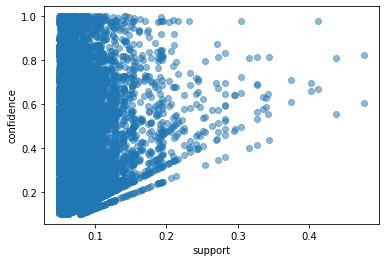

In [36]:
# Filter rules based on support and confidence thresholds
rules5 = rules3[(rules3['support'] >= 0.05) & (rules3['confidence'] >= 0.1)]

# Visualize rules using scatter plots, heat maps, or network diagrams
plt.scatter(rules5['support'], rules5['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

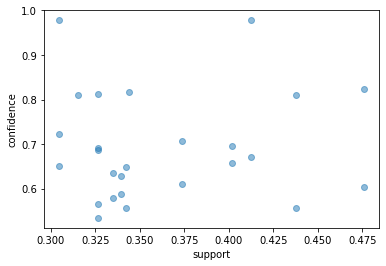

In [37]:
# Filter rules based on support and confidence thresholds
rules6 = rules3[(rules3['support'] >= 0.3) & (rules3['confidence'] >= 0.5)]

# Visualize rules using scatter plots, heat maps, or network diagrams
plt.scatter(rules6['support'], rules6['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

## Predict the new customer group

In [46]:
# Perform association rule mining
frequent_itemsets = apriori(existing1_encode, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Sort the rules based on confidence and support levels
rules = rules.sort_values(['confidence', 'support'], ascending=[False, False])

# Create columns for predicted group and probability of each group
for group in ['A', 'B', 'C', 'D']:
    new1_encode[f'predicted_{group}'] = 0
    new1_encode[f'probability_{group}'] = 0.0

# Apply the association rules to the new customer data
for index, row in new1_encode.iterrows():
    for _, rule in rules.iterrows():
        if rule['antecedents'].issubset(row):
            group = list(rule['consequents'])[0]
            new1_encode.at[index, f'predicted_{group}'] = 1
            new1_encode.at[index, f'probability_{group}'] = rule['confidence']

# Determine the predicted group for each new customer
predicted_groups = []
for index, row in new1_encode.iterrows():
    predicted_group = ''
    max_probability = 0.0
    for group in ['A', 'B', 'C', 'D']:
        if row[f'predicted_{group}'] == 1 and row[f'probability_{group}'] > max_probability:
            predicted_group = group
            max_probability = row[f'probability_{group}']
    if predicted_group == '':
        predicted_group = 'Unknown'
    predicted_groups.append(predicted_group)

# Add the predicted group column to the new customer data
new1_encode['predicted_group'] = predicted_groups

# Print the predicted group for each new customer
print(new1_encode['predicted_group'])


0       Unknown
1       Unknown
3       Unknown
4       Unknown
5       Unknown
         ...   
2622    Unknown
2623    Unknown
2624    Unknown
2625    Unknown
2626    Unknown
Name: predicted_group, Length: 2589, dtype: object


In [39]:
# Perform association rule mining
frequent_itemsets = apriori(existing1_encode, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Sort the rules based on confidence and support levels
rules = rules.sort_values(['confidence', 'support'], ascending=[False, False])
# Initialize the predicted group columns as all zeros
new1_encode['A'] = 0
new1_encode['B'] = 0
new1_encode['C'] = 0
new1_encode['D'] = 0

# Apply the association rules to the new customer data
for index, row in new1_encode.iterrows():
    for _, rule in rules.iterrows():
        if rule['antecedents'].issubset(row):
            group = list(rule['consequents'])[0]
            new1_encode.at[index, f'group_{group}'] = 1

# Print the predicted group for each new customer
print(new1_encode[['A', 'B', 'C', 'D']])

      A  B  C  D
0     0  0  0  0
1     0  0  0  0
3     0  0  0  0
4     0  0  0  0
5     0  0  0  0
...  .. .. .. ..
2622  0  0  0  0
2623  0  0  0  0
2624  0  0  0  0
2625  0  0  0  0
2626  0  0  0  0

[2589 rows x 4 columns]


In [40]:
# Perform association rule mining
frequent_itemsets = apriori(existing1_encode, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Sort the rules based on confidence and support levels
rules = rules.sort_values(['confidence', 'support'], ascending=[False, False])
# Assign the predicted group for each new customer based on the association rules
new1_encode['predicted_group'] = 'Unknown'
for index, row in new1_encode.iterrows():
    for _, rule in rules.iterrows():
        if rule['antecedents'].issubset(row):
            new1_encode.at[index, 'predicted_group'] = list(rule['consequents'])[0]

# Map the predicted group values to the group names (A, B, C, D)
group_map = {'A': 'Group A', 'B': 'Group B', 'C': 'Group C', 'D': 'Group D'}
new1_encode['predicted_group'] = new1_encode['predicted_group'].map(group_map)

In [41]:
# Print the predicted group for each new customer
print(new1_encode['predicted_group'])

0       NaN
1       NaN
3       NaN
4       NaN
5       NaN
       ... 
2622    NaN
2623    NaN
2624    NaN
2625    NaN
2626    NaN
Name: predicted_group, Length: 2589, dtype: object


In [42]:
groups = ['A', 'B', 'C', 'D']

In [43]:
# Perform association rule mining
frequent_itemsets = apriori(existing1_encode, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Sort the rules based on confidence and support levels
rules = rules.sort_values(['confidence', 'support'], ascending=[False, False])

new1_encode['predicted_group'] = groups[0] # initialize with the first group name
for index, row in new1_encode.iterrows():
    for _, rule in rules.iterrows():
        if rule['antecedents'].issubset(row):
            new1_encode.at[index, 'predicted_group'] = list(rule['consequents'])[0]


In [44]:
# Print the predicted group for each new customer
print(new1_encode['predicted_group'])

0       Work_Experience_Range_0-5
1       Work_Experience_Range_0-5
3       Work_Experience_Range_0-5
4       Work_Experience_Range_0-5
5       Work_Experience_Range_0-5
                  ...            
2622    Work_Experience_Range_0-5
2623    Work_Experience_Range_0-5
2624    Work_Experience_Range_0-5
2625    Work_Experience_Range_0-5
2626    Work_Experience_Range_0-5
Name: predicted_group, Length: 2589, dtype: object


In [45]:
# Perform association rule mining
frequent_itemsets = apriori(existing1_encode, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Sort the rules based on confidence and support levels
rules = rules.sort_values(['confidence', 'support'], ascending=[False, False])

# Apply the association rules to the new customer data
new1_encode['predicted_group'] = 'Unknown'
for index, row in new1_encode.iterrows():
    for _, rule in rules.iterrows():
        if rule['antecedents'].issubset(row):
            # Assign the predicted group based on the consequent of the association rule
            predicted_group = list(rule['consequents'])[0]
            if predicted_group == 'A':
                new1_encode.at[index, 'predicted_group'] = 'Group A'
            elif predicted_group == 'B':
                new1_encode.at[index, 'predicted_group'] = 'Group B'
            elif predicted_group == 'C':
                new1_encode.at[index, 'predicted_group'] = 'Group C'
            elif predicted_group == 'D':
                new1_encode.at[index, 'predicted_group'] = 'Group D'

# Print the predicted group for each new customer
print(new1_encode['predicted_group'])


0       Unknown
1       Unknown
3       Unknown
4       Unknown
5       Unknown
         ...   
2622    Unknown
2623    Unknown
2624    Unknown
2625    Unknown
2626    Unknown
Name: predicted_group, Length: 2589, dtype: object
